In [58]:
# The code was removed by Watson Studio for sharing.

In [59]:
import pandas as pd
from datetime import datetime
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from dse_do_utils import DataManager, OptimizationEngine,ScenarioManager

# Unit Informations

In [60]:
MODEL_NAME = 'Unit_Commitment'
SCENARIO_NAME = 'Base_Scenario' 
sm = ScenarioManager(model_name=MODEL_NAME, scenario_name=SCENARIO_NAME, project = project)

In [61]:
InputTables, outputTables = sm.load_data_from_scenario()
InputTables.keys()

dict_keys(['Units', 'Demand'])

In [62]:
Units = InputTables['Units']

Demand = InputTables['Demand']

# Optimization

In [63]:
def continuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.continuous_var_list(df.index, **kargs), index = df.index)

def binary_var_series(df, mdl,**kargs):
    return pd.Series(mdl.binary_var_list(df.index, **kargs), index = df.index)

def integer_var_series(df, mdl,**kargs):
    '''Create a Series of integer dvar for each row in the DF. Most effective method. Best practice.
    Result can be assigned to a column of the df.
    Usage:
        df['xDVar'] = mdl.integer_var_series(df, name = 'xDVar')
    Args:
        mdl: CPLEX Model
        df: DataFrame
        **kargs: arguments passed to mdl.integer_var_list method. E.g. 'name'
        
    :returns: pandas.Series with integer dvars, index matches index of df
    '''
    #We are re-using the index from the DF index:
    return pd.Series(mdl.integer_var_list(df.index, **kargs), index = df.index)


class CplexSum():
    """Function class that adds a series of dvars into a cplex sum expression.
    To be used as a custom aggregation in a groupby.
    Usage:
        df2 = df1.groupby(['a']).agg({'xDVar':CplexSum(engine.mdl)}).rename(columns={'xDVar':'expr'})

    Sums the dvars in the 'xDVar' column into an expression
    """
    def __init__(self, mdl):
        self.mdl = mdl
    def __call__(self, dvar_series):
        return self.mdl.sum(dvar_series)

# Define decision variables

In [64]:
from docplex.mp.model import Model
mdl = Model("Unit_Commitment")

in use[u,t] is true iff unit u is in production at period t

In [65]:
Unit_Date = pd.merge(Units[["Unit"]],Demand["Date_Sequence"], how = "cross" )

Unit_Date = Unit_Date.set_index(["Unit","Date_Sequence"], verify_integrity = True)

Unit_Date.head(6)

Empty DataFrame
Columns: []
Index: [(coal1, day1), (coal1, day2), (coal1, day3), (coal1, day4), (coal1, day5), (coal1, day6)]

in use[u,t] is true iff unit u is in production at period t

In [66]:
Unit_Date["x_InUse"] = binary_var_series(Unit_Date, mdl,name = 'x_InUse')

true if unit u is turned on at period t

In [67]:
Unit_Date["x_TurnOn"] = binary_var_series(Unit_Date, mdl,name = 'x_TurnOn')

true if unit u is switched off at period t

modeled as a continuous 0-1 variable, more on this later

In [68]:
Unit_Date["x_TurnOff"] = continuous_var_series(Unit_Date, mdl,name = 'x_TurnOff')

 production of energy for unit u at period t

In [69]:
Unit_Date["x_Production"] = continuous_var_series(Unit_Date, mdl,name = 'x_Production')

In [70]:
Unit_Date = Unit_Date.reset_index(drop = False)

In [71]:
Unit_Date.head()

,Unit,Date_Sequence,x_InUse,x_TurnOn,x_TurnOff,x_Production
0,coal1,day1,x_InUse_coal1_day1,x_TurnOn_coal1_day1,x_TurnOff_coal1_day1,x_Production_coal1_day1
1,coal1,day2,x_InUse_coal1_day2,x_TurnOn_coal1_day2,x_TurnOff_coal1_day2,x_Production_coal1_day2
2,coal1,day3,x_InUse_coal1_day3,x_TurnOn_coal1_day3,x_TurnOff_coal1_day3,x_Production_coal1_day3
3,coal1,day4,x_InUse_coal1_day4,x_TurnOn_coal1_day4,x_TurnOff_coal1_day4,x_Production_coal1_day4
4,coal1,day5,x_InUse_coal1_day5,x_TurnOn_coal1_day5,x_TurnOff_coal1_day5,x_Production_coal1_day5


In [72]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# Constraints

# 2- Linking in-use status to production
Whenever the unit is in use, the production must be within the minimum and maximum generation.

In [73]:
Production_range = pd.merge ( Unit_Date[["Unit","x_InUse","x_Production"]] , Units[["Unit","min_gen","max_gen"]], on = "Unit")

Production_range.head()

,Unit,x_InUse,x_Production,min_gen,max_gen
0,coal1,x_InUse_coal1_day1,x_Production_coal1_day1,100.0,425
1,coal1,x_InUse_coal1_day2,x_Production_coal1_day2,100.0,425
2,coal1,x_InUse_coal1_day3,x_Production_coal1_day3,100.0,425
3,coal1,x_InUse_coal1_day4,x_Production_coal1_day4,100.0,425
4,coal1,x_InUse_coal1_day5,x_Production_coal1_day5,100.0,425


When in use, the production level is constrained to be between min and max generation.

In [74]:
for row in Production_range.itertuples():
    mdl.add_constraint ( row.x_Production <= row.x_InUse * row.max_gen )
    mdl.add_constraint ( row.x_Production >= row.x_InUse * row.min_gen )

In [75]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 3840
   - linear=3840
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# 3 -Initial state
If initial production is nonzero, then period #1 is not a turn_on
else turn_on equals in_use
Dual logic is implemented for turn_off

In [76]:
initial_state  = Units [["Unit","initial"]]
day_1 = Unit_Date[Unit_Date["Date_Sequence"]=="day1"]

initial_state = pd.merge (initial_state, day_1, on = "Unit")
initial_state

,Unit,initial,Date_Sequence,x_InUse,x_TurnOn,x_TurnOff,x_Production
0,coal1,400,day1,x_InUse_coal1_day1,x_TurnOn_coal1_day1,x_TurnOff_coal1_day1,x_Production_coal1_day1
1,coal2,350,day1,x_InUse_coal2_day1,x_TurnOn_coal2_day1,x_TurnOff_coal2_day1,x_Production_coal2_day1
2,gas1,205,day1,x_InUse_gas1_day1,x_TurnOn_gas1_day1,x_TurnOff_gas1_day1,x_Production_gas1_day1
3,gas2,52,day1,x_InUse_gas2_day1,x_TurnOn_gas2_day1,x_TurnOff_gas2_day1,x_Production_gas2_day1
4,gas3,155,day1,x_InUse_gas3_day1,x_TurnOn_gas3_day1,x_TurnOff_gas3_day1,x_Production_gas3_day1
5,gas4,150,day1,x_InUse_gas4_day1,x_TurnOn_gas4_day1,x_TurnOff_gas4_day1,x_Production_gas4_day1
6,diesel1,78,day1,x_InUse_diesel1_day1,x_TurnOn_diesel1_day1,x_TurnOff_diesel1_day1,x_Production_diesel1_day1
7,diesel2,76,day1,x_InUse_diesel2_day1,x_TurnOn_diesel2_day1,x_TurnOff_diesel2_day1,x_Production_diesel2_day1
8,diesel3,0,day1,x_InUse_diesel3_day1,x_TurnOn_diesel3_day1,x_TurnOff_diesel3_day1,x_Production_diesel3_day1
9,diesel4,0,day1,x_InUse_diesel4_day1,x_TurnOn_diesel4_day1,x_TurnOff_diesel4_day1,x_Production_diesel4_day1


In [77]:
for row in initial_state.itertuples():
    if row.initial > 0 :   
            
            mdl.add_constraint  ( row.x_TurnOn == 0)                   #if u is already running, not starting up
            
            mdl.add_constraint  ( row.x_TurnOff +  row.x_InUse == 1)   # turnoff iff not in use
            
            
    else: 
        
           mdl.add_constraint ( row.x_TurnOn  == row.x_InUse )        # turn on at 1 iff in use at 1
            
           mdl.add_constraint(row.x_TurnOff ==0)                      # already off, not switched off at t==1

In [78]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 3860
   - linear=3860
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# 4 Ramp-up / ramp-down constraint

ramp up and down constraints for day 1
    
Variations of the production level over time in a unit is constrained by a ramp-up / ramp-down process.

We use the  pandas groupby operation to collect all decision variables for each unit in separate series. Then, we iterate over units to post constraints enforcing the ramp-up / ramp-down process by setting upper bounds on the variation of the production level for consecutive periods.

In [79]:
for unit in Units["Unit"].values:
    a = Unit_Date [ (Unit_Date["Unit"]==unit) & (Unit_Date["Date_Sequence"]=="day1")]
    b = Units [ Units["Unit"]==unit][["Unit","initial","ramp_up","ramp_down"]]
    r = pd.merge (a , b,  on ="Unit")
    
    mdl.add_constraint ( r.x_Production[0] - r.initial[0] <= r.ramp_up[0] )
    
    mdl.add_constraint( r.initial[0] - r.x_Production[0] <= r.ramp_down[0])
    

    # ramp up and down constraints for remaining days

In [80]:
Ramp_Table = pd.DataFrame()

for unit in Units["Unit"].values:
    a = Unit_Date[Unit_Date["Unit"]==unit][["Unit","Date_Sequence","x_Production"]]
    a.rename(columns = {"x_Production":"Current_Day_Production"}, inplace = True)   
    a["Next_Day_Production"] = a["Current_Day_Production"].shift(-1)       # shift 1 day to calculate next day production
    a = a.iloc[0:-1]                                                       # get rid of last row, which has a NaN for next day production
    
    Ramp_Table = pd.concat([Ramp_Table,a])

Ramp_Table = pd.merge(Ramp_Table,Units[["Unit",'ramp_up','ramp_down']], on = "Unit") 

Ramp_Table.sample(7)

,Unit,Date_Sequence,Current_Day_Production,Next_Day_Production,ramp_up,ramp_down
242,coal2,day52,x_Production_coal2_day52,x_Production_coal2_day53,150.0,198.0
347,coal2,day157,x_Production_coal2_day157,x_Production_coal2_day158,150.0,198.0
1735,diesel4,day17,x_Production_diesel4_day17,x_Production_diesel4_day18,12.0,12.0
297,coal2,day107,x_Production_coal2_day107,x_Production_coal2_day108,150.0,198.0
1817,diesel4,day99,x_Production_diesel4_day99,x_Production_diesel4_day100,12.0,12.0
1095,gas4,day141,x_Production_gas4_day141,x_Production_gas4_day142,50.0,60.0
967,gas4,day13,x_Production_gas4_day13,x_Production_gas4_day14,50.0,60.0


In [81]:
for row in Ramp_Table.itertuples():
    mdl.add_constraint(row.Next_Day_Production - row.Current_Day_Production <= row.ramp_up)
    
    mdl.add_constraint(row.Current_Day_Production - row.Next_Day_Production <= row.ramp_down)

In [82]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 7700
   - linear=7700
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# 5 Turn on / turn off
The following constraints determine when a unit is turned on or off.

We use the same pandas groupby operation as in the previous constraint to iterate over the sequence of decision variables for each unit.

In [83]:
Status = pd.DataFrame([])

for unit in Units["Unit"].values:
    a = Unit_Date[Unit_Date["Unit"]==unit][["Unit","x_InUse","x_TurnOn","x_TurnOff"]]
    
    a.rename(columns = {"x_InUse":"Current_Day_InUse"}, inplace = True)
    a.rename(columns = {"x_TurnOn":"Current_Day_TurnOn"}, inplace = True)
    a.rename(columns = {"x_TurnOff":"Current_Day_TurnOff"}, inplace = True)
    
    a["Next_Day_InUse"] = a["Current_Day_InUse"].shift(-1)       # shift 1 day to calculate next day InUse
    a["Next_Day_TurnOn"] = a["Current_Day_TurnOn"].shift(-1)       # shift 1 day to calculate next day TurnOn
    a["Next_Day_TurnOff"] = a["Current_Day_TurnOff"].shift(-1)       # shift 1 day to calculate next day TurnOff
    
    a = a.iloc[0:-1]                                                # get rid of last row, which has a NaN
    
    Status = pd.concat([Status,a])
        
display(Status.sample(10))

,Unit,Current_Day_InUse,Current_Day_TurnOn,Current_Day_TurnOff,Next_Day_InUse,Next_Day_TurnOn,Next_Day_TurnOff
1883,diesel4,x_InUse_diesel4_day156,x_TurnOn_diesel4_day156,x_TurnOff_diesel4_day156,x_InUse_diesel4_day157,x_TurnOn_diesel4_day157,x_TurnOff_diesel4_day157
1719,diesel3,x_InUse_diesel3_day184,x_TurnOn_diesel3_day184,x_TurnOff_diesel3_day184,x_InUse_diesel3_day185,x_TurnOn_diesel3_day185,x_TurnOff_diesel3_day185
394,gas1,x_InUse_gas1_day11,x_TurnOn_gas1_day11,x_TurnOff_gas1_day11,x_InUse_gas1_day12,x_TurnOn_gas1_day12,x_TurnOff_gas1_day12
440,gas1,x_InUse_gas1_day57,x_TurnOn_gas1_day57,x_TurnOff_gas1_day57,x_InUse_gas1_day58,x_TurnOn_gas1_day58,x_TurnOff_gas1_day58
1639,diesel3,x_InUse_diesel3_day104,x_TurnOn_diesel3_day104,x_TurnOff_diesel3_day104,x_InUse_diesel3_day105,x_TurnOn_diesel3_day105,x_TurnOff_diesel3_day105
872,gas3,x_InUse_gas3_day105,x_TurnOn_gas3_day105,x_TurnOff_gas3_day105,x_InUse_gas3_day106,x_TurnOn_gas3_day106,x_TurnOff_gas3_day106
1200,diesel1,x_InUse_diesel1_day49,x_TurnOn_diesel1_day49,x_TurnOff_diesel1_day49,x_InUse_diesel1_day50,x_TurnOn_diesel1_day50,x_TurnOff_diesel1_day50
923,gas3,x_InUse_gas3_day156,x_TurnOn_gas3_day156,x_TurnOff_gas3_day156,x_InUse_gas3_day157,x_TurnOn_gas3_day157,x_TurnOff_gas3_day157
119,coal1,x_InUse_coal1_day120,x_TurnOn_coal1_day120,x_TurnOff_coal1_day120,x_InUse_coal1_day121,x_TurnOn_coal1_day121,x_TurnOff_coal1_day121
1150,gas4,x_InUse_gas4_day191,x_TurnOn_gas4_day191,x_TurnOff_gas4_day191,x_InUse_gas4_day192,x_TurnOn_gas4_day192,x_TurnOff_gas4_day192


if unit is off at time t and on at time t+1, then it was turned on at time t+1

if unit is on at time t and off at time t+1, then it was turned off at time t+1

In [84]:
for row in Status.itertuples():
    
    #print(row.Next_Day_InUse - row.Current_Day_InUse <= row.Next_Day_TurnOn)
    mdl.add_constraint(row.Next_Day_InUse - row.Current_Day_InUse <= row.Next_Day_TurnOn)
    
    #print(row.Current_Day_InUse - row.Next_Day_InUse + row.Next_Day_TurnOn == row.Next_Day_TurnOff)
    mdl.add_constraint(row.Current_Day_InUse - row.Next_Day_InUse + row.Next_Day_TurnOn == row.Next_Day_TurnOff)

In [85]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 11520
   - linear=11520
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# 6 Minimum uptime and downtime
When a unit is turned on, it cannot be turned off before a minimum uptime. Conversely, when a unit is turned off, it cannot be turned on again before a minimum downtime.

Again, let's use the same pandas groupby operation to implement this constraint for each unit.

In [86]:
T = len(Demand)

for unit in Units["Unit"].values:
    a= Units[Units["Unit"]==unit][["Unit","min_uptime","min_downtime"]]
    
    min_uptime = a.min_uptime.values[0] 
    min_downtime = a.min_downtime.values[0] 
    
    for t in range(min_uptime,T):
        mdl.add_constraint(mdl.sum(  Unit_Date[(t - min_uptime) + 1   :   t + 1 ][["x_TurnOn"]].values) <= Unit_Date["x_InUse"][t] ) 
        
        
    for t in range(min_downtime, T):   
        mdl.add_constraint(mdl.sum( Unit_Date[(t - min_downtime) + 1:t + 1]["x_TurnOff"].values)  <= 1 - Unit_Date["x_InUse"][t]  ) 

In [87]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15263
   - linear=15263
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# 1- Demand

In [88]:
Total_day_Production = Unit_Date[["Date_Sequence","x_Production"]].groupby("Date_Sequence").agg(CplexSum(mdl)).rename(columns={"x_Production":"Total_day_Production"})
Total_day_Production = pd.merge(Total_day_Production, Demand, on = "Date_Sequence")

Total_day_Production.head(2)

,Date_Sequence,Total_day_Production,demand,Date
0,day1,x_Production_coal1_day1+x_Production_coal2_day1+x_Production_gas1_day1+x_Production_gas2_day1+x_Production_gas3_day1+x_Production_gas4_day1+x_Production_diesel1_day1+x_Production_diesel2_day1+x_Production_diesel3_day1+x_Production_diesel4_day1,1259.0,2022-04-22
1,day10,x_Production_coal1_day10+x_Production_coal2_day10+x_Production_gas1_day10+x_Production_gas2_day10+x_Production_gas3_day10+x_Production_gas4_day10+x_Production_diesel1_day10+x_Production_diesel2_day10+x_Production_diesel3_day10+x_Production_diesel4_day10,1158.0,2022-05-01


In [89]:
for row in Total_day_Production.itertuples():
    
    mdl.add_constraint(row.Total_day_Production >= row.demand)

In [90]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15455
   - linear=15455
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [91]:
Units.head(1)

,index,energy,initial,min_gen,max_gen,operating_max_gen,min_uptime,min_downtime,ramp_up,ramp_down,start_cost,fixed_cost,variable_cost,Unit,co2_cost
0,0,coal,400,100.0,425,400,15,9,212.0,183.0,5000,208.61,22.536,coal1,30


In [92]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15455
   - linear=15455
 - parameters: defaults
 - objective: none
 - problem type is: MILP


demand constraint

Total production level must be equal or higher than demand on any period.

This time, the pandas operation groupby is performed on "periods" since we have to iterate over the list of all units for each period.

In [93]:
Unit_Date.head(1)

,Unit,Date_Sequence,x_InUse,x_TurnOn,x_TurnOff,x_Production
0,coal1,day1,x_InUse_coal1_day1,x_TurnOn_coal1_day1,x_TurnOff_coal1_day1,x_Production_coal1_day1


In [94]:
mdl.print_information()

Model: Unit_Commitment
 - number of variables: 7680
   - binary=3840, integer=0, continuous=3840
 - number of constraints: 15455
   - linear=15455
 - parameters: defaults
 - objective: none
 - problem type is: MILP


# KPIs

In [95]:
cost = pd.merge ( Unit_Date, Units[["Unit","fixed_cost","variable_cost","start_cost","co2_cost"]], on = "Unit")
cost.head()

,Unit,Date_Sequence,x_InUse,x_TurnOn,x_TurnOff,x_Production,fixed_cost,variable_cost,start_cost,co2_cost
0,coal1,day1,x_InUse_coal1_day1,x_TurnOn_coal1_day1,x_TurnOff_coal1_day1,x_Production_coal1_day1,208.61,22.536,5000,30
1,coal1,day2,x_InUse_coal1_day2,x_TurnOn_coal1_day2,x_TurnOff_coal1_day2,x_Production_coal1_day2,208.61,22.536,5000,30
2,coal1,day3,x_InUse_coal1_day3,x_TurnOn_coal1_day3,x_TurnOff_coal1_day3,x_Production_coal1_day3,208.61,22.536,5000,30
3,coal1,day4,x_InUse_coal1_day4,x_TurnOn_coal1_day4,x_TurnOff_coal1_day4,x_Production_coal1_day4,208.61,22.536,5000,30
4,coal1,day5,x_InUse_coal1_day5,x_TurnOn_coal1_day5,x_TurnOff_coal1_day5,x_Production_coal1_day5,208.61,22.536,5000,30


In [96]:
total_fixed_cost = mdl.sum(cost.x_InUse * cost.fixed_cost)
total_variable_cost = mdl.sum(cost.x_Production * cost.variable_cost)
total_startup_cost = mdl.sum(cost.x_TurnOn * cost.start_cost)
total_co2_cost = mdl.sum(cost.x_Production * cost.co2_cost)

total_economic_cost = total_fixed_cost + total_variable_cost + total_startup_cost

total_nb_used = mdl.sum(Unit_Date.x_InUse)
total_nb_starts = mdl.sum(Unit_Date.x_TurnOn)


# store expression kpis to retrieve them later.
mdl.add_kpi(total_fixed_cost   , "Total Fixed Cost")
mdl.add_kpi(total_variable_cost, "Total Variable Cost")
mdl.add_kpi(total_startup_cost , "Total Startup Cost")
mdl.add_kpi(total_economic_cost, "Total Economic Cost")
mdl.add_kpi(total_co2_cost     , "Total CO2 Cost")
mdl.add_kpi(total_nb_used, "Total #used")
mdl.add_kpi(total_nb_starts, "Total #starts")

# minimize sum of all costs
mdl.minimize(total_fixed_cost + total_variable_cost + total_startup_cost + total_co2_cost)

Solve

In [97]:
mdl.solve()

def extract_solution(df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}_Solution'] = [dvar.solution_value for dvar in df[xDVarName]]
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df


In [98]:
mdl.report()

* model Unit_Commitment solved with objective = 14209449.983
*  KPI: Total Fixed Cost    = 157918.371
*  KPI: Total Variable Cost = 8831785.112
*  KPI: Total Startup Cost  = 13189.000
*  KPI: Total Economic Cost = 9002892.483
*  KPI: Total CO2 Cost      = 5206557.500
*  KPI: Total #used         = 1317.000
*  KPI: Total #starts       = 11.000


# Create output tables

In [99]:
outputs = {}

In [100]:
plan = extract_solution(Unit_Date,extract_dvar_names= ['x_TurnOn','x_TurnOff','x_Production','x_InUse'] , drop=True)
plan.round(2).head()

,Unit,Date_Sequence,x_TurnOn_Solution,x_TurnOff_Solution,x_Production_Solution,x_InUse_Solution
0,coal1,day1,0.0,0.0,425.0,1.0
1,coal1,day2,0.0,0.0,425.0,1.0
2,coal1,day3,0.0,0.0,425.0,1.0
3,coal1,day4,0.0,0.0,425.0,1.0
4,coal1,day5,0.0,0.0,425.0,1.0


In [101]:
Power_portions = plan[["Unit","Date_Sequence","x_Production_Solution"]].groupby(["Date_Sequence","Unit"]).sum().round().reset_index(drop = False)
Power_portions = pd.merge(Power_portions, Demand[["Date","Date_Sequence"]], on = "Date_Sequence")
Power_portions.head()

,Date_Sequence,Unit,x_Production_Solution,Date
0,day1,coal1,425.0,2022-04-22
1,day1,coal2,215.0,2022-04-22
2,day1,diesel1,90.0,2022-04-22
3,day1,diesel2,87.0,2022-04-22
4,day1,diesel3,0.0,2022-04-22


In [102]:
#plan[["Date_Sequence","x_InUse_Solution"]].groupby("Date_Sequence").agg(sum).plot()

In [103]:
outputs['plan'] = plan
outputs['Power_portions'] = Power_portions

In [104]:
sm.outputs = outputs
sm.update_solve_output_into_scenario(mdl, outputs)

In [105]:
Demand.head()

,demand,Date,Date_Sequence
0,1259.0,2022-04-22,day1
1,1439.0,2022-04-23,day2
2,1289.0,2022-04-24,day3
3,1211.0,2022-04-25,day4
4,1433.0,2022-04-26,day5


In [106]:
plan[["Unit","x_InUse_Solution"]]

,Unit,x_InUse_Solution
0,coal1,1.0
1,coal1,1.0
2,coal1,1.0
3,coal1,1.0
4,coal1,1.0
5,coal1,1.0
6,coal1,1.0
7,coal1,1.0
8,coal1,1.0
9,coal1,1.0


<AxesSubplot:title={'center':'Number of plants online'}>

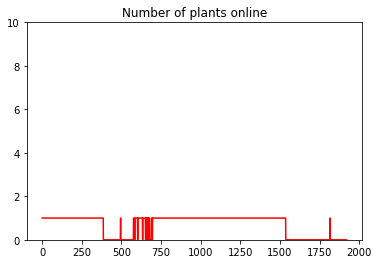

In [107]:
plan["x_InUse_Solution"].plot(title="Number of plants online", kind='line', style="r-", ylim=[0, len(Units)])